# Exploring the XBT dataset

This notebook explores the XBT dataset and considers how the distribution of the arious metadata fields may present challenges in using machine learning to fill in unknown metadata. In particular we are interested in the *instrument* field in the raw data, which is split into *model* and *manufacturer* when read in by the XbtDataset class, and the distribution of observations into  different categories of model and manufacturer.

<img src='https://upload.wikimedia.org/wikipedia/commons/e/ee/Launching-an-expendable-bathythermograph-XBT.jpg' style="height:300px">

In [1]:
import os
import pandas
import csv
import matplotlib
import matplotlib.pyplot
import cartopy.crs as ccrs
import bokeh
import ipywidgets
import numpy
import functools

In [2]:
from xbt_dataset import XbtDataset

In [3]:
# TODO: access through a intake catalog
# Set up some constants for the notebook
xbt_data_dir = '/data/misc/xbt-data/annual_csv/'
DATA_YEAR_RANGE=(1966,2016)
columns = ['year','num obs ''num cruises', 'unknown brand or type',
           'unknown type', 'num_instruments','num_platforms']

# Geographic location of observations
An important aspect of the metadata is the correlation between geographic location and the model/manufacturer of the probe. This interactive plot allows one to plot where observations from a particular time period are located, for all types or for particular types.

In [4]:
@functools.lru_cache
def get_dataset(data_dir, year):
    return XbtDataset(data_dir, (year, year+1))


In [5]:
xbt_full_dataset = XbtDataset(xbt_data_dir, DATA_YEAR_RANGE)

In [6]:
parent_widget = None
def do_plot(year, instrument, show_unknown):
    figure_name = f'xbt_data_plot'
    xbt_year = xbt_full_dataset.filter_obs('year', year)
    if parent_widget:
        parent_widget.widget.children[1].options = xbt_year.instruments + ['all']
    current_figure = matplotlib.pyplot.figure(figure_name, figsize=(16,16))
    projection1 = ccrs.PlateCarree()
    current_axes = current_figure.add_subplot(111, projection=projection1)
    current_axes.coastlines()
    xbt_subset = xbt_year.filter_obs('labelled', show_unknown)
    if instrument == 'all':
        data_subset_df = xbt_subset.xbt_df
    else:
        data_subset_df = xbt_subset.filter_obs('instrument', instrument).xbt_df
    current_axes.plot(numpy.array( data_subset_df.lon), numpy.array(data_subset_df.lat), 'r+')
    current_axes.set_title(f'XBT {year} instrument={instrument}')
    current_axes.set_xlim((-180.0,180.0))
    current_axes.set_ylim((-90.0,90.0))
    current_axes.set_xticks([-180, -120, -60.0, 0, 60, 120, 180], crs=projection1)
    current_axes.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=projection1)


In [7]:
instr_list = xbt_full_dataset.instruments + ['all']
parent_widget = ipywidgets.interact(do_plot, year=DATA_YEAR_RANGE, instrument=instr_list, show_unknown=['all', 'labelled','unlabelled'])

interactive(children=(IntSlider(value=1991, description='year', max=2016, min=1966), Dropdown(description='ins…

# Frequency of model and manufacturer
An important consideration in applying a machine learning algorithm to this data is the distribution of class labels. A naive application of ML algorithms for classification usually assumes a reasonably even distribution among classes.

In [8]:
num_to_plot = 20

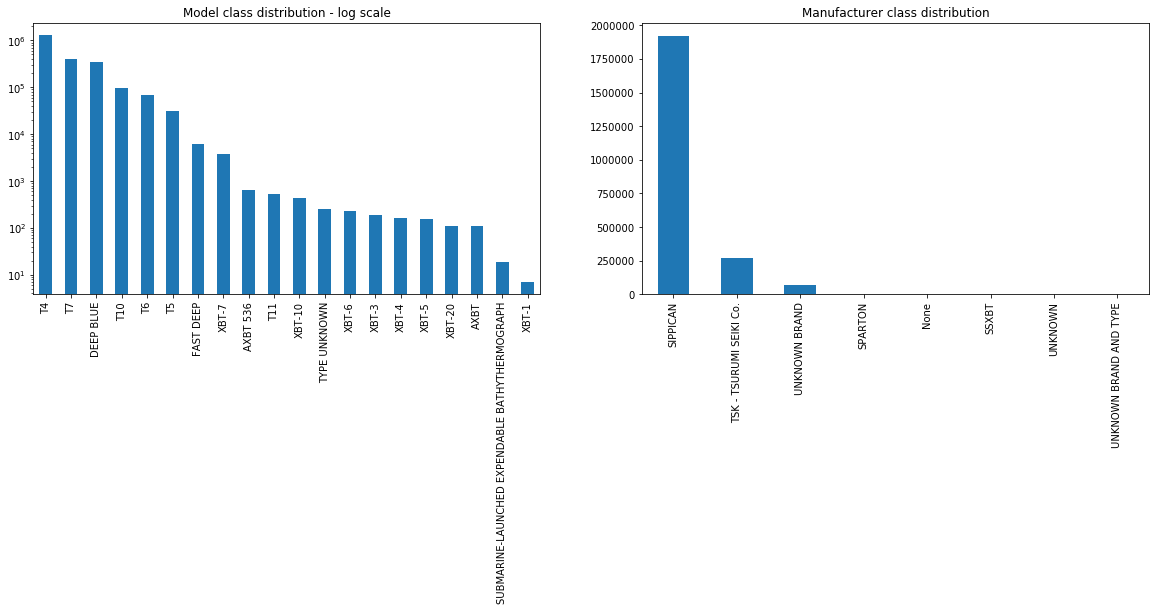

In [9]:
fig_name = 'xbt_plot_model_manu'
fig1 = matplotlib.pyplot.figure(fig_name)
axis_country = fig1.add_subplot(121)
axis_country.set_title('Model class distribution - log scale')
xbt_full_dataset.xbt_df['model'].value_counts()[:num_to_plot].plot(kind='bar',ax=axis_country,figsize=(20,5), logy=True )
axis_inst = fig1.add_subplot(122)
axis_inst.set_title('Manufacturer class distribution')
xbt_full_dataset.xbt_df['manufacturer'].value_counts()[:num_to_plot].plot(kind='bar',ax=axis_inst,figsize=(20,5))

## Frequency of other metadata

We also want to understand how other metadata such as country and platform are distributed. Information about correlations between different metadata fields will be investiagted in a later section.

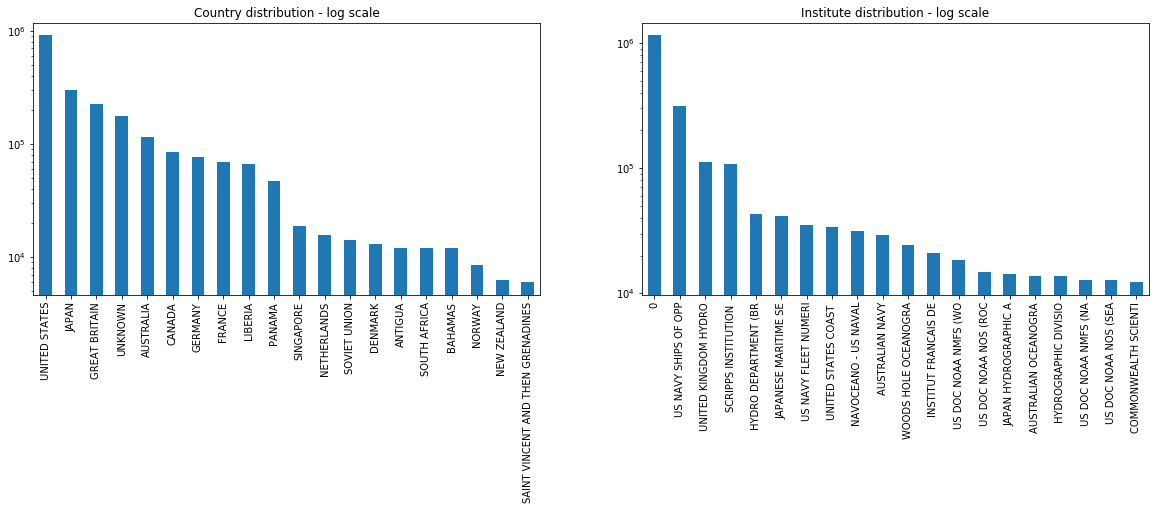

In [10]:
fig_name = 'xbt_country_and_inst'
fig1 = matplotlib.pyplot.figure(fig_name)
axis_country = fig1.add_subplot(121)
axis_country.set_title('Country distribution - log scale')
xbt_full_dataset.xbt_df['country'].value_counts()[:num_to_plot].plot(kind='bar',ax=axis_country,figsize=(20,5), logy=True )
axis_inst = fig1.add_subplot(122)
axis_inst.set_title('Institute distribution - log scale')
xbt_full_dataset.xbt_df['institute'].apply(lambda s1:s1[:20]).value_counts()[:num_to_plot].plot(kind='bar',ax=axis_inst,figsize=(20,5), logy=True)

### Plot obs per year
Show plots of obs per year with known and unknown models and manufacturers

In [11]:
unknown_manufacturer_by_year = []
known_manufacturer_by_year = []
unknown_model_by_year = []
known_model_by_year = []
for year in range(*DATA_YEAR_RANGE):
    xbt_ds1 = xbt_full_dataset.filter_obs('year', year)
    unknown_manufacturer_by_year += [xbt_ds1.num_unknown_manufacturer]
    known_manufacturer_by_year += [xbt_ds1.known_manufacturer_dataset.shape[0]]
    unknown_model_by_year += [xbt_ds1.num_unknown_model]
    known_model_by_year += [xbt_ds1.known_model_dataset.shape[0]]    

Text(0.5,1,'num observations with model label per year')

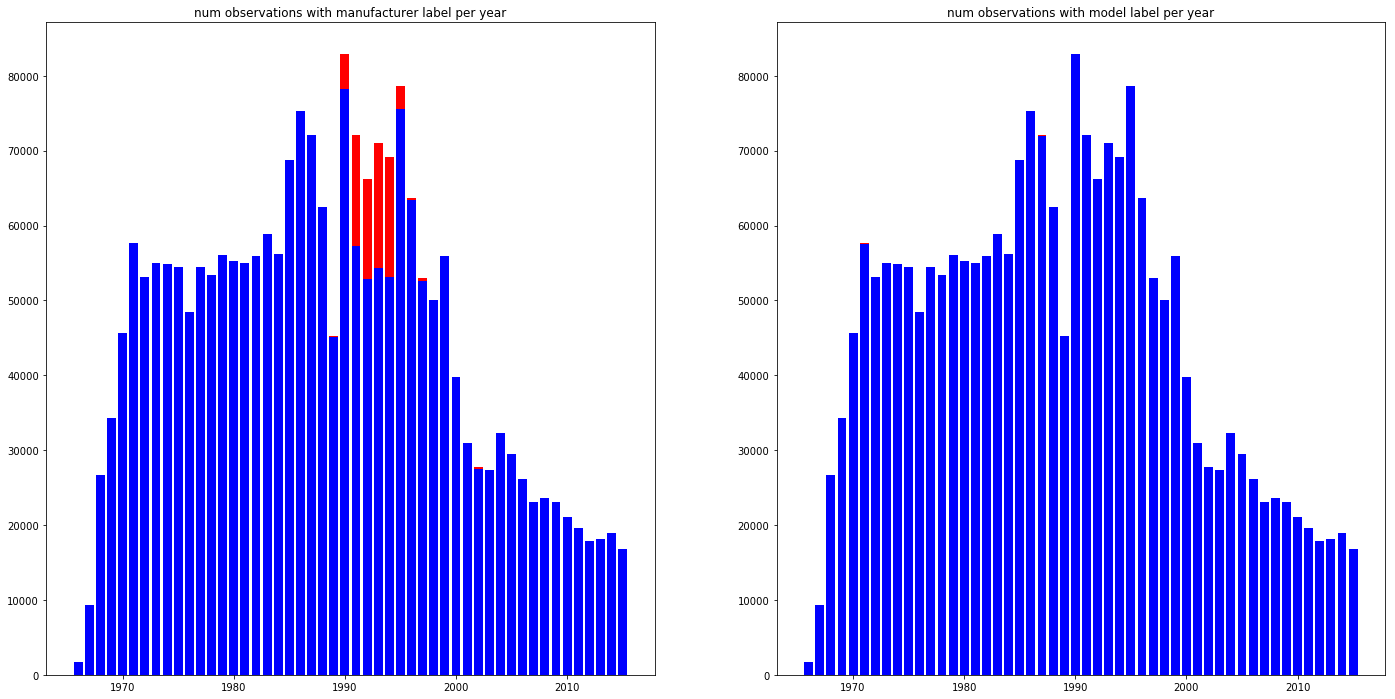

In [12]:
figure_name = f'xbt_unknown_manufacturer'
current_figure = matplotlib.pyplot.figure(figure_name, figsize=(24,12))
current_axes = current_figure.add_subplot(121)
current_axes.bar(range(*DATA_YEAR_RANGE), known_manufacturer_by_year, color='b')
current_axes.bar(range(*DATA_YEAR_RANGE), unknown_manufacturer_by_year, bottom=known_manufacturer_by_year, color='r')
current_axes.set_title('num observations with manufacturer label per year')
current_axes = current_figure.add_subplot(122)
current_axes.bar(range(*DATA_YEAR_RANGE), known_model_by_year, color='b')
current_axes.bar(range(*DATA_YEAR_RANGE), unknown_model_by_year, bottom=known_model_by_year, color='r')
current_axes.set_title('num observations with model label per year')


We can see that there are very small numbers of missing model fields for any of the years in the dataset. For most years, there are also very few observations with missing manufacturer metadata, but there are some year in the 1980s and 1990s with a more substantial number of observations with missing manufacturer information, up to 20% in a few years.

## Missing model/manufacturer per cruise

We also interested in what percentage of cruises in a given year have complete metadata information for model & manufacturer compared to how many cruises there are where 1 or more observation is missing the model or manufacturer metadata.

We want to know information about those cruises where some of the observations are missing metadata. In particular, do cruises with such observations have other observations where the metadata is present? Do such cruises have all observations from the same probetypes, or do they have multiple prove types?

In [16]:
unknown_model_years = []
unknown_manufacturer_years = []
num_cruises = []
num_all_known_model = []
num_all_known_manufacturer = []
for year in range(*DATA_YEAR_RANGE):
    cs, nu_model, nu_manufacturer = xbt_full_dataset.filter_obs('year', year).get_cruise_stats()
    num_cruises += [len(cs)]
    unknown_model_years += [nu_model]
    num_all_known_model += [len(cs) - nu_model]
    unknown_manufacturer_years += [nu_manufacturer]
    num_all_known_manufacturer += [len(cs) - nu_manufacturer]


Text(0.5,1,'num cruises per year with no or some observations with unknown manufacturers')

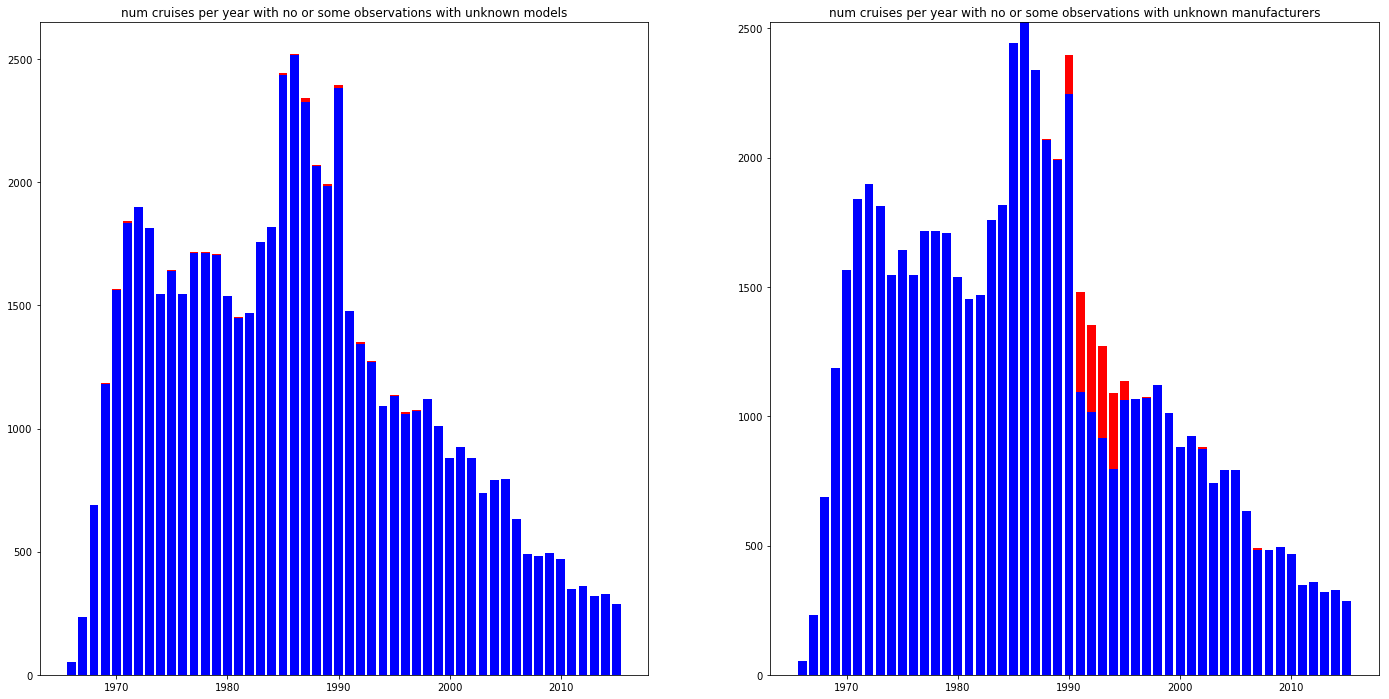

In [18]:
figure_name = f'xbt_cruises_unknowns'
current_figure = matplotlib.pyplot.figure(figure_name, figsize=(24,12))
current_axes = current_figure.add_subplot(121)
current_axes.bar(range(*DATA_YEAR_RANGE), num_all_known_model, color='b')
current_axes.bar(range(*DATA_YEAR_RANGE), unknown_model_years, bottom=num_all_known_model, color='r')
current_axes.set_title('num cruises per year with no or some observations with unknown models')
current_axes = current_figure.add_subplot(122)
current_axes.bar(range(*DATA_YEAR_RANGE), num_all_known_manufacturer, color='b')
current_axes.bar(range(*DATA_YEAR_RANGE), unknown_manufacturer_years, bottom=num_all_known_manufacturer, color='r')
current_axes.set_title('num cruises per year with no or some observations with unknown manufacturers')